In [32]:
import importlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sub import estimate

importlib.reload(estimate)

plt.rcParams["figure.figsize"] = (20, 12)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [33]:
LOG_FILE_PATH = "../dataset/sample-trials/4_1_51.txt"
GIS_BASE_PATH = "../dataset/gis/"
BEACON_LIST_PATH = GIS_BASE_PATH + "beacon_list.csv"
FLOOR_NAMES = ["FLU01", "FLU02", "FLD01"]

In [34]:
from sub import pdr

importlib.reload(pdr)

data = pdr.read_log_data(LOG_FILE_PATH)
acc_df, gyro_df, mgf_df, ground_truth_df, blescans_df = pdr.convert_to_dataframes(data)

In [35]:
from sub import pdr

importlib.reload(pdr)

map_dict = pdr.load_floor_maps(FLOOR_NAMES, GIS_BASE_PATH)
edit_map_dict = pdr.load_floor_maps(FLOOR_NAMES, GIS_BASE_PATH, "_edited")
floor_name = ground_truth_df.floor_name[0]

dx = 0.01
dy = 0.01

In [36]:
from scipy.signal import find_peaks

acc_df["norm"] = np.sqrt(acc_df["x"] ** 2 + acc_df["y"] ** 2 + acc_df["z"] ** 2)
acc_df["rolling_norm"] = acc_df["norm"].rolling(10).mean()

peaks, _ = find_peaks(acc_df["rolling_norm"], height=12, distance=10)

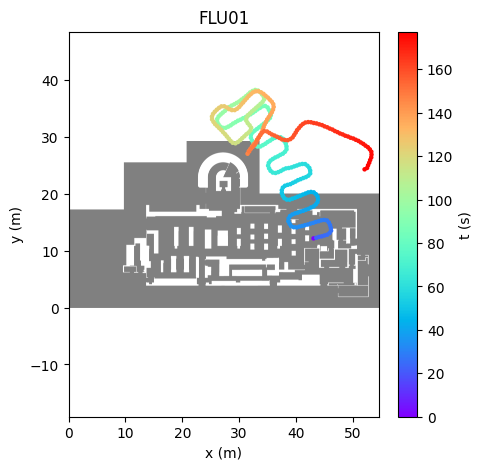

In [37]:
from sub import pdr, utils

importlib.reload(utils)
importlib.reload(pdr)

cumulative_displacement_angle, trajectory_df = pdr.estimate_trajectory(
    acc_df,
    gyro_df,
    ground_truth_first_point={
        "x": ground_truth_df.x[0],
        "y": ground_truth_df.y[0],
    },
)

utils.plot_displacement_map(
    map_dict,
    floor_name,
    dx,
    dy,
    trajectory_df,
)

initial_direction: 0.8316046661187979


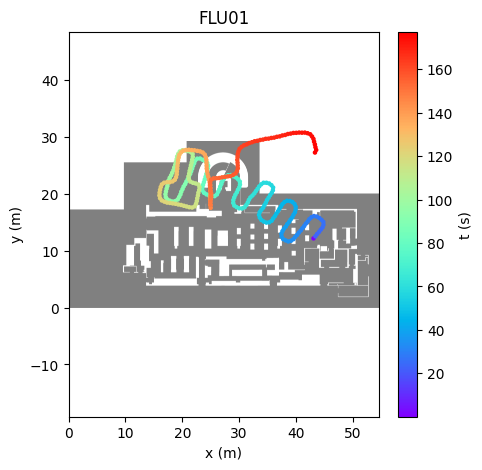

In [38]:
from sub import utils

importlib.reload(utils)

initial_direction = utils.extract_rotation(
    [
        ground_truth_df.q0[0],
        ground_truth_df.q1[0],
        ground_truth_df.q2[0],
        ground_truth_df.q3[0],
    ],
)

print(f"initial_direction: {initial_direction}")

angle_df = estimate.convert_to_angle_from_gyro(gyro_df)
angle_df_in_step_timing = estimate.convert_to_peek_angle(gyro_df, acc_df, peaks)
diff = angle_df_in_step_timing["x"][0] - initial_direction
rotate_by_first_half_angle = pd.DataFrame(
    {
        "ts": angle_df["ts"],
        "x": angle_df["x"] - diff,
    },
)

rotate_by_first_half_angle_displacement = (
    estimate.convert_to_peek_angle_and_compute_displacement_by_angle(
        rotate_by_first_half_angle,
        acc_df,
        0.5,
        {"x": ground_truth_df.x[0], "y": ground_truth_df.y[0]},
        ground_truth_df["ts"][0],
    )
)

utils.plot_displacement_map(
    map_dict,
    floor_name,
    dx,
    dy,
    rotate_by_first_half_angle_displacement,
)

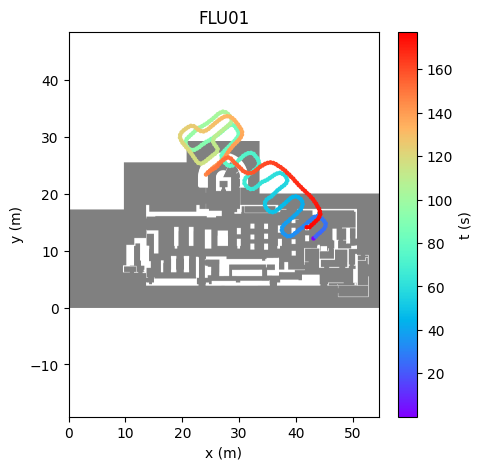

In [39]:
from sub import drift, utils

importlib.reload(drift)
importlib.reload(utils)


first_time_remove_drift_angle, first_time_remove_drift_angle_displacement = (
    drift.remove_drift_in_angle_df(
        acc_df,
        rotate_by_first_half_angle,
        ground_truth_df,
    )
)


# マップの描画
utils.plot_displacement_map(
    map_dict,
    floor_name,
    dx,
    dy,
    first_time_remove_drift_angle_displacement,
    fig_size=(5, 5),
)

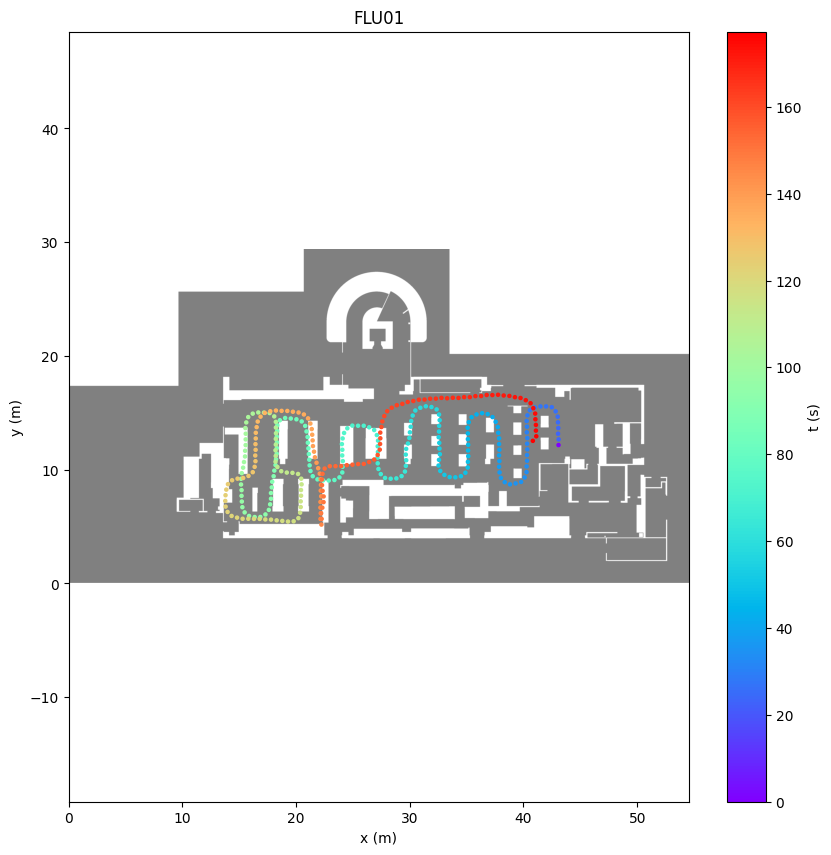

In [40]:
# refactored code

from sub import estimate, pdr_direction, utils

importlib.reload(pdr_direction)
importlib.reload(utils)
importlib.reload(estimate)

straight_angle_df, straight_angle_displacement = (
    pdr_direction.rotate_trajectory_to_optimal_alignment_using_map(
        acc_df,
        first_time_remove_drift_angle,
        edit_map_dict,
        floor_name,
        dx,
        dy,
        ground_truth_first_point={
            "x": ground_truth_df.x[0],
            "y": ground_truth_df.y[0],
        },
    )
)

utils.plot_displacement_map(
    map_dict,
    floor_name,
    dx,
    dy,
    straight_angle_displacement,
    fig_size=(10, 10),
)

水平成分と垂直成分の色を変更するコード

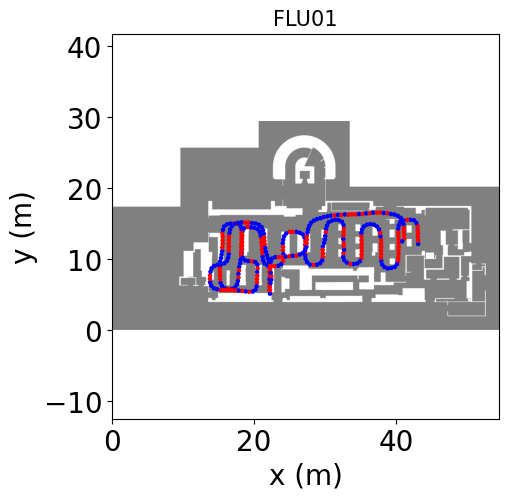

In [41]:
from sub import utils

importlib.reload(utils)

utils.plot_map(map_dict, floor_name, dx, dy, font_size=15, fig_size=(5, 5))

colors = straight_angle_displacement["is_vertical_or_horizontal"].map(
    {True: "r", False: "b", np.nan: "b"},
)

plt.scatter(
    straight_angle_displacement.x_displacement,
    straight_angle_displacement.y_displacement,
    c=colors,
    s=5,
)
plt.tick_params(labelsize=20)
plt.xlabel("x (m)", fontsize=20)
plt.ylabel("y (m)", fontsize=20)
plt.show()

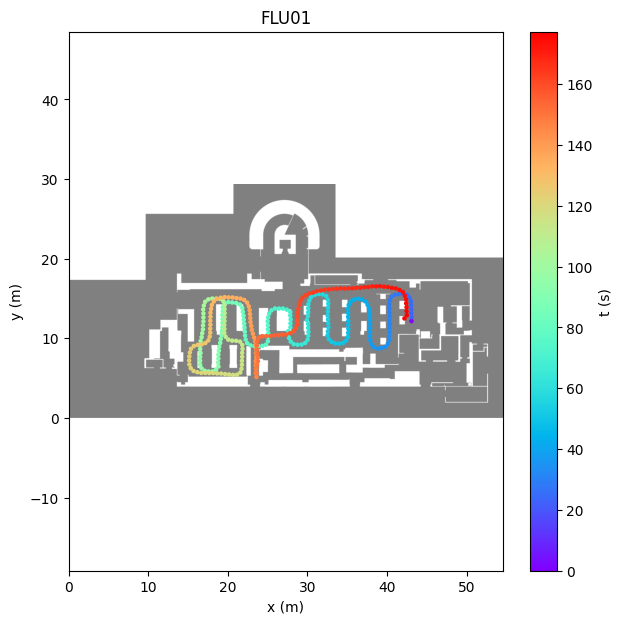

In [44]:
from sub import estimate, map_matching, stable, utils

importlib.reload(estimate)
importlib.reload(map_matching)
importlib.reload(stable)
importlib.reload(utils)

correct_unpassable_displacement = map_matching.move_unwalkable_points_to_walkable(
    acc_df,
    straight_angle_df,
    map_dict,
    floor_name,
    dx,
    dy,
    ground_truth_first_point={
        "x": ground_truth_df.x[0],
        "y": ground_truth_df.y[0],
    },
)


utils.plot_displacement_map(
    map_dict,
    floor_name,
    dx,
    dy,
    correct_unpassable_displacement,
    fig_size=(7, 7),
    font_size=10,
    label_size=10,
)

In [68]:
from sub import estimate, map_matching, stable, utils

importlib.reload(map_matching)


map_matching.move_unwalkable_points_to_walkable2(
    acc_df,
    straight_angle_df,
    map_dict,
    floor_name,
    dx,
    dy,
    ground_truth_first_point={
        "x": ground_truth_df.x[0],
        "y": ground_truth_df.y[0],
    },
)



{'direction_error_coefficient': 1.0000000000000002, 'stride_length_error_coefficient': 0.8019047619047622}
{'direction_error_coefficient': 1.0000000000000002, 'stride_length_error_coefficient': 0.8066666666666669}
{'direction_error_coefficient': 1.0000000000000002, 'stride_length_error_coefficient': 0.8038095238095241}
{'direction_error_coefficient': 1.0000000000000002, 'stride_length_error_coefficient': 0.8061904761904763}
{'direction_error_coefficient': 1.0000000000000002, 'stride_length_error_coefficient': 0.8061904761904763}
{'direction_error_coefficient': 1.0000000000000002, 'stride_length_error_coefficient': 0.8038095238095241}
{'direction_error_coefficient': 1.0000000000000002, 'stride_length_error_coefficient': 0.807619047619048}
{'direction_error_coefficient': 1.0000000000000002, 'stride_length_error_coefficient': 0.8000000000000002}
{'direction_error_coefficient': 1.0000000000000002, 'stride_length_error_coefficient': 0.8080952380952384}
{'direction_error_coefficient': 0.9985

,ts,x_displacement,y_displacement
0,0.000000,43.079905,12.163538
1,22.887179,43.080679,12.203001
2,23.518216,43.077110,12.242310
3,24.075389,43.078822,12.281743
4,24.600236,43.076456,12.321142
5,25.076593,43.074817,12.360579
6,25.653061,43.060713,12.397443
7,26.120688,43.033925,12.426431
8,26.761847,42.994891,12.432284
9,27.276752,42.955421,12.432310


In [ ]:
output_df = pd.DataFrame(
    {
        "timestamp": correct_unpassable_displacement["ts"],
        "x": correct_unpassable_displacement["x_displacement"],
        "y": correct_unpassable_displacement["y_displacement"],
        "floor": floor_name,
    },
)

# output_df.to_csv("8_1_pdr_est.csv", index=False, header=False)